# Successive Over-relaxation (SOR)

In this section, we want to examine another parallel algorithm called Successive Over-relaxation (SOR). 

The SOR algorithm is an iterative method used to solve Laplace equations. The underlying data structure of the SOR algorithm is a two-dimensional grid, whose elements are updated iteratively through some weighted function that considers the old value as well as the values of neighbouring cells. 

![Grid](images/SOR_grid_painted.png)

This algorithm is applied, for instance, in physics to simulate the climate or temperature of some object.


Climate Simulation          |  Temperature of a metal plate
:------:|:----:
![](images/SOR_climate_simulation.png) |  ![](images/SOR_temperature_metal_plate.png)


## Sequential algorithm

The sequential SOR algorithm is as follows (where `f` is some update function and `N`,`M` are the grid sizes):

```julia
grid = zeros(N, M)
grid_new = zeros(N, M)
for step in 1:NSTEPS
   for i in 2:N #update grid
        for j in 2:M
           grid_new[i,j] = f(grid[i,j], grid[i-1,j], grid[i+1,j], grid[i,j-1], grid[i,j+1])
        end
    end
end
```

## Diffusion equation on grid 

Consider the diffusion of a chemical substance on a two-dimensional grid. The concentration of the chemical is given as $c(x,y)$, a function of the coordinates $x$ and $y$. We will consider a square grid with $0 \leq x,y \leq 1$ and the boundary conditions $c(x,y=1) = 1$ and $c(x,y=0) = 0$. That is, the concentration at the top of the grid is always 1 and the concentration at the very bottom is always 0. Furthermore, in the x-direction we will assume periodic boundary conditions, i.e. $c(x=0, y) = c(x=1,y)$. 

![diffusion](images/SOR_time_dep_diffusion.png)

We will take the initial condition $c(x,y) = 0$ for $0 \leq x \leq 1, 0 \leq y < 1$.

The stable state of the diffusion, that is, when the concentraion does not change anymore, can be described by the Laplace equation

$$
\nabla^2 c = 0.
$$

Numerically, we can approximate the solution with the Jacobi iteration 

$$
\frac{1}{4}(c^k_{i,j+1} + c^k_{i,j-1} + c^k_{i+1,j} + c^k_{i-1,j}) = c^{k+1}_{i,j}.
$$

The superscript $k$ denotes the $k$-th iteration. The algorithm stepwise updates the cells of the grid, until a steady state is reached. To determine the end of the algorithm, we use the stopping condition 

$$
\max_{i,j} \lvert c^{k+1}_{i,j} - c^{k}_{i,j} \rvert < \epsilon.
$$

That is, we stop when all changes to cell values are smaller than some small number, say $\epsilon = 10^{-5}$.

Furthermore, for this set of initial and boundary conditions, there exists an analytical solution for the stable state, namely 
$$
c(x,y) = y.
$$
That is, the concentration profile is the identity function of the y-coordinate. 

## Serial Program

In [1]:
# Update grid until threshold reached
function update_grid!(new_grid, grid, M, N)
    @assert grid[1,:] == grid[M-1,:]
    @assert grid[M,:] == grid[2,:] 
    @assert grid[:,1] == fill(0,M) == new_grid[:,1]
    @assert grid[:,N] == fill(1,M) == new_grid[:,N]
    # Remove ghost cells
   g_left = grid[1:M-2, 2:N-1]
   g_right = grid[3:M, 2:N-1]
   g_up = grid[2:M-1, 3:N]
   g_down = grid[2:M-1, 1:N-2]
    # Jacobi iteration
   new_grid[2:M-1,2:N-1] = 0.25 * (g_up + g_down + g_left + g_right)
   # Update ghost cells
   new_grid[1,:] = new_grid[M-1,:]
   new_grid[M,:] = new_grid[2,:]
    return new_grid
end

function SOR!(new_grid, grid, ϵ, M, N)
    grid_old = true
    while true
        if grid_old
            update_grid!(new_grid, grid, M, N)
        else 
            update_grid!(grid, new_grid, M, N)
        end
        # Flip boolean value
        grid_old = !grid_old
        diffs = abs.(new_grid[2:M-1, :] - grid[2:M-1, :])
        if maximum(diffs) < ϵ
            break
        end
    end 
end



SOR! (generic function with 1 method)

In [2]:
using Test, Plots
N = 100
M = N + 2
ϵ = 10^-5

# initialize grid
grid = zeros(M,N)
grid[:,N] .= 1
new_grid = zeros(M,N)
new_grid[:,N] .= 1

update_grid!(new_grid, grid, M, N)

# Test if first iteration successful
@test all(new_grid[:,N-1] .≈ fill(0.25, M))
@test all(new_grid[:,N-2] .≈ fill(0,M))
@test all(new_grid[:,N] == fill(1,M))
@test all(new_grid[:,1] == fill(0,M))

Test Passed

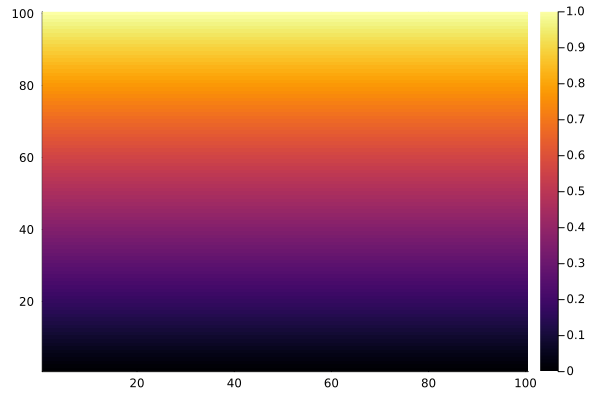

In [3]:
N = 100
M = N + 2
ϵ = 10^-5

# initialize grid
grid = zeros(M,N)
grid[:,N] .= 1
new_grid = zeros(M,N)
new_grid[:,N] .= 1

SOR!(new_grid, grid, ϵ, M, N)
plt = heatmap(transpose(new_grid[2:M-1,:]))
display(plt)

In [4]:
# analytical solution
function analytical_solution(N)
    # Returns the analytical solution as a square grid of size N
   grid = zeros(N,N)
   for i in 2:N
        grid[:,i] .= (i-1)/(N-1)
    end
    return grid
end

# Test if solution is identical with analytical solution
sol = analytical_solution(N)
@test maximum(abs.(sol - new_grid[2:M-1,:])) < 0.01 * N

Test Passed

## Parallel Program with MPI

In [5]:
#] add MPIClusterManagers DelimitedFiles

In [6]:
# to import MPIManager
using MPIClusterManagers

# need to also import Distributed to use addprocs()
using Distributed

# specify, number of mpi workers, launch cmd, etc.
manager=MPIWorkerManager(9)

# start mpi workers and add them as julia workers too.
addprocs(manager)

@mpi_do manager begin
    
function calculate_partition(p, N, nrows, ncols)
    # Calculates the row and column indices of this processor
    # Get row and column number for processor p 
    if mod(p,ncols) == 0
        i = div(p,ncols)
    else
        i = floor(div(p,ncols)) + 1
    end
    j = p - (i-1)*ncols
    # Rows
    if mod(N,nrows) == 0
        prows = div(N, nrows)
        row_range =((i-1) * prows + 1) : (i*prows)
    else
        # nlower processors get the smaller partition
        nlower = nrows - (mod(N,nrows)) 
        n_floor = floor(div(N,nrows))
        if i <= nlower
            row_range =((i-1) * n_floor + 1) : (i*n_floor)
        else
            row_range = ((i-1) * n_floor + (i - nlower)) : (i*n_floor + (i-nlower))
        end
    end
    # Columns
    if mod(N,ncols) == 0
        prows = div(N, ncols)
        col_range =((j-1) * prows + 1) : (j*prows)
    else
        nlower = ncols - (mod(N,ncols)) 
        n_floor = floor(div(N,ncols))
        if j <= nlower
            col_range =((j-1) * n_floor + 1) : (j*n_floor)
        else
            col_range = ((j-1) * n_floor + (j - nlower)) : (j*n_floor + (j-nlower))
        end
    end
    # Add 1 to each column index because of ghost cells
    col_range = col_range .+ 1
    return row_range, col_range
end

    
function update_grid(grid)
   # Returns the updated grid as M-2 x N-2 matrix where M and N are sizes of grid
   M = size(grid, 1)
   N = size(grid, 2) 
   # Remove ghost cells
   g_left = grid[2:M - 1,1:N-2]
   g_right = grid[2:M - 1, 3:N]
   g_up = grid[1:M-2, 2:N-1]
   g_down = grid[3:M, 2:N-1]
    # Jacobi iteration
   return 0.25 * (g_up + g_down + g_left + g_right)
end

  using MPI
  comm=MPI.COMM_WORLD
  id = MPI.Comm_rank(comm) + 1
    

  M = 50
  N = M + 2
  ϵ = 10^-5  # Stopping threshold
  nrows = 3  # Number of grid rows
  ncols = 3  # Number of grid columns
  n_procs = nrows * ncols
  @assert n_procs == MPI.Comm_size(comm)
  max_diffs = ones(n_procs) # Differences between iterations
  max_diff_buf = MPI.UBuffer(max_diffs,1) # Buffer to store maximum differences
  

  # initialize grid
  if id == 1
      grid_a = zeros(M,N)
      grid_a[1,:] .= 1
      grid_b = zeros(M,N)
      grid_b[1,:] .= 1
  else
      grid_a = nothing
      grid_b = nothing
  end
 
  # Broadcast matrix to other processors
  grid_a = MPI.bcast(grid_a, 0, comm)
  grid_b = MPI.bcast(grid_b, 0, comm)

  # Determine if processor is in top or bottom row of grid
  top_pos = id <= ncols
  bottom_pos = id > ((nrows-1) * ncols)
  local grid_a_old = false # Grid a is the source grid for the first update

  # Get local partition
  ind_rows, ind_cols = calculate_partition(id, M, nrows, ncols)
  println("Proc $(id) gets rows $(ind_rows) and columns $(ind_cols)")

  # Determine neighbors
  n_left = id - 1
  n_right = id + 1
  n_down = id + ncols
  n_up = id - ncols
  if mod(id, ncols) == 1
    # Left neighbor is last in row
    n_left = id + ncols - 1
  end 
  if mod(id, ncols) == 0
    # Right neighbor is first in row
    n_right = id - ncols + 1
  end

  #println("Proc $(id) has neighbors left $(n_left) and right $(n_right) and up $(n_up) and down $(n_down)")

  local finished = false

  #Perform SOR
  while !finished
      # Flip old and new grid
      grid_a_old = !grid_a_old 
    
      # Determine which grid is updated
      if grid_a_old 
        old_grid = grid_a
        new_grid = grid_b
      else
        old_grid = grid_b
        new_grid = grid_a
      end      
    
      # send left and right columns
      left_ind = first(ind_cols)
      right_ind = last(ind_cols)
      left_col = old_grid[ind_rows, left_ind]
      right_col = old_grid[ind_rows, right_ind]
      slreq = MPI.Isend(left_col, comm; dest=n_left-1)
      srreq = MPI.Isend(right_col, comm; dest=n_right-1)
    
      # Send bottom row if not bottom
      bottom_ind = last(ind_rows)
      if !bottom_pos
        bottom_col = old_grid[bottom_ind, ind_cols]
        sbreq = MPI.Isend(bottom_col, comm; dest=n_down -1)
      end

      # Send top row if not at the top 
      top_ind = first(ind_rows)
      if !top_pos
        top_row = old_grid[top_ind, ind_cols]
        streq = MPI.Isend(top_row, comm; dest = n_up -1)
      end

      # Receive left and right column
      left_buf = Array{Float64,1}(undef, length(ind_rows))
      right_buf = Array{Float64,1}(undef, length(ind_rows))
      rlreq = MPI.Irecv!(left_buf, comm; source=n_left -1)
      rrreq = MPI.Irecv!(right_buf, comm; source=n_right -1)

       # Receive top row if not at the top
      if !top_pos
        top_buf = Array{Float64,1}(undef, length(ind_cols))
        rtreq = MPI.Irecv!(top_buf, comm; source=n_up -1)
      end

      # Receive bottom row if not at the bottom 
      if !bottom_pos
        bottom_buf = Array{Float64,1}(undef, length(ind_cols))
        rbreq = MPI.Irecv!(bottom_buf, comm; source=n_down -1)
      end

      # Wait for results
      statlr = MPI.Waitall([rlreq, rrreq], MPI.Status)
      old_grid[ind_rows, left_ind - 1] = left_buf
      old_grid[ind_rows, right_ind + 1] = right_buf
      #println("Proc $(id) received left $(old_grid[ind_rows, left_ind - 1]) and right $(old_grid[ind_rows, right_ind + 1])")
    
      if !top_pos
        statt = MPI.Wait(rtreq)
        old_grid[top_ind - 1, ind_cols] = top_buf
        #println("Proc $(id) received top $(old_grid[top_ind - 1, ind_cols])")
      end

      if !bottom_pos
        statb = MPI.Wait(rbreq)
        old_grid[bottom_ind + 1, ind_cols] = bottom_buf
        #println("Proc $(id) received bottom $(old_grid[bottom_ind + 1, ind_cols])")
      end 

      # Get local subgrid
      if !top_pos & !bottom_pos
          local_with_ghosts = old_grid[top_ind - 1 : bottom_ind + 1, left_ind - 1 : right_ind + 1]
          lb_row = top_ind
          ub_row = bottom_ind
      elseif top_pos 
          local_with_ghosts = old_grid[top_ind : bottom_ind + 1, left_ind - 1 : right_ind + 1]
          lb_row = top_ind + 1
          ub_row = bottom_ind
      elseif bottom_pos
          local_with_ghosts = old_grid[top_ind - 1 : bottom_ind, left_ind - 1 : right_ind + 1]
          lb_row = top_ind
          ub_row = bottom_ind - 1
      end

      # Perform one step of Jacobi iteration
      new_grid[lb_row : ub_row, left_ind : right_ind] = update_grid(local_with_ghosts)

      # Calculate max difference
      diffs = abs.(new_grid[lb_row : ub_row, left_ind : right_ind] - old_grid[lb_row : ub_row, left_ind : right_ind])
      maxdiff = maximum(diffs)
    
      # Gather maxdiffs in processor 1 
      MPI.Gather!(maxdiff, max_diff_buf, comm; root=0)

      # First processor determines if threshold is exeeded
      if id == 1
        if all(max_diffs .< ϵ)
            finished = true
            println("THRESHOLD SUBCEEDED - TERMINATE SOR")     
        end
      end
    
      finished = MPI.bcast(finished, 0, comm)

      if finished
        # Set ghost cells to zero again so MPI.Reduce gives correct output
        new_grid[ind_rows, left_ind - 1] .= 0.0
        new_grid[ind_rows, right_ind + 1] .= 0.0
        if !bottom_pos
            new_grid[bottom_ind + 1, ind_cols] .= 0.0
        end
        if !top_pos
            new_grid[top_ind - 1, ind_cols] .= 0.0
        end
      end
  end

  using DelimitedFiles

  # Reduce matrix & store result
  if !grid_a_old
      sor_result = grid_a
  else 
      sor_result = grid_b
  end

  MPI.Reduce!(sor_result, +, comm, root = 0)
  sor_result[1,:] .= 1.0
  if id == 1
    writedlm("SOR_result.txt", sor_result)
  end 

  MPI.Finalize()
end

      From worker 5:	Proc 4 gets rows 17:33 and columns 2:17
      From worker 8:	Proc 7 gets rows 34:50 and columns 2:17
      From worker 3:	Proc 2 gets rows 1:16 and columns 18:34
      From worker 6:	Proc 5 gets rows 17:33 and columns 18:34
      From worker 9:	Proc 8 gets rows 34:50 and columns 18:34
      From worker 4:	Proc 3 gets rows 1:16 and columns 35:51
      From worker 10:	Proc 9 gets rows 34:50 and columns 35:51
      From worker 7:	Proc 6 gets rows 17:33 and columns 35:51
      From worker 2:	Proc 1 gets rows 1:16 and columns 2:17
      From worker 2:	THRESHOLD SUBCEEDED - TERMINATE SOR


In [7]:
rmprocs(manager);

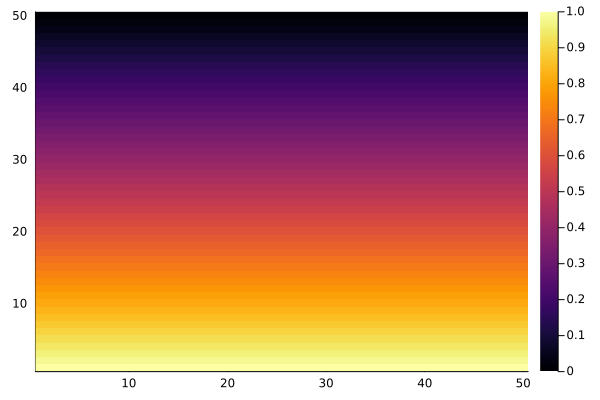

In [8]:
using Plots, DelimitedFiles
final_grid = readdlm("SOR_result.txt")
M = size(final_grid, 1)
N = size(final_grid, 2)
plt = heatmap(final_grid[:, 2:N-1])
display(plt)

In [9]:
# Test if solution is identical with analytical solution
sol = analytical_solution(M)
# Bring solution into correct form 
sol = reverse(transpose(sol), dims = 1)
@test maximum(abs.(sol - final_grid[:,2:N-1])) < 0.01 * M

Test Passed